## Parameter Fitting to a Simple Series Reaction

jbr book reference: [Figure A.10](https://sites.engineering.ucsb.edu/~jbraw/chemreacfun/fig-html/appendix/fig-A-10.html)

Reaction is $A \xrightarrow[]{k_1} B \xrightarrow[]{k_2} C$

Data simulated for $A$, $B$, and $C$ over time (with added noise) based on:
$ c_{A0} = 1, c_{B0} = 0, c_{c0} = 0, k_1 = 2, k_2 = 1$

The above parameters are also the parameters that will be fitted based on the data

In [1]:
from kipet import KipetModel
import numpy as np
import pyomo.environ as pyo
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import t

    Set objects from pyomo.core.base.set or pyomo.core.  (deprecated in 5.7)
    (called from <frozen importlib._bootstrap>:219)
_SetProduct not found


In [16]:
dirname = '/home/paperspace/learn_kipet/kipet_paresto/data_sets/'
filename = dirname + 'ABC_data.csv'
C_data = pd.read_csv(filename, index_col = 0)

In [17]:
C_data.columns = ['A', 'B', 'C']
C_data

,A,B,C
t,,,
0.000,0.957,-0.031,-0.015
0.263,0.557,0.330,0.044
0.526,0.342,0.512,0.156
0.789,0.224,0.499,0.310
1.053,0.123,0.428,0.454
1.316,0.079,0.396,0.556
1.579,0.035,0.303,0.651
1.842,0.029,0.287,0.658
2.105,0.025,0.221,0.750


In [18]:
C_data = C_data.iloc[[8, 9]]
C_data

,A,B,C
t,,,
2.105,0.025,0.221,0.750
2.368,0.017,0.148,0.854


In [19]:
kipet_model = KipetModel()

r1 = kipet_model.new_reaction('rxn1')

r1.add_component('A', state = 'concentration', init = 1.0)
r1.add_component('B', state = 'concentration', init = 0.0)
r1.add_component('C', state = 'concentration', init = 0.0)

r1.add_parameter('k1',init = 5.0, bounds=(0.0,10.0))
r1.add_parameter('k2',init = 5.0, bounds=(0.0,10.0))
r1.add_parameter('ca0', init = 1.0, bounds = (0.5, 1.5))
r1.add_parameter('cb0', init = 0.0, bounds = (0.0, 1.5))
r1.add_parameter('cc0', init = 0.0, bounds = (0.0, 1.5))

In [20]:
# define explicit system of ODEs
def rule_odes(m,t):
    exprs = dict()
    exprs['A'] = -m.P['k1']*m.Z[t,'A']
    exprs['B'] = m.P['k1']*m.Z[t,'A']-m.P['k2']*m.Z[t,'B']
    exprs['C'] = m.P['k2']*m.Z[t,'B']
    return exprs

r1.add_equations(rule_odes)
r1.set_times(0.0, 5.0)

In [21]:
r1.add_dataset('C_data', category = 'concentration', data = C_data)

In [22]:
r1.create_pyomo_model()

times are: <class 'tuple'>
0.0 5.0
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (sigma) to be 'Any', you can suppress this
    warning by explicitly specifying 'within=Any' to the Param constructor.
    (deprecated in 5.6.9, will be removed in 6.0) (called from
    /home/paperspace/my_pyenvs/kipetenv/lib/python3.7/site-
    packages/Pyomo-5.7.1-py3.7-linux-x86_64.egg/pyomo/core/base/param.py:640)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (sigma) to be 'Any', you can suppress this
    warning by explicitly specifying 'within=Any' to the Param constructor.
    (deprecated in 5.6.9, will be removed in 6.0) (called from
    /home/paperspace/my_pyenvs/kipetenv/lib/python3.7/site-
    packages/Pyomo-5.7.1-py3.7-linux-x86_64.egg/pyomo/core/base/param.py:640)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the doma

In [23]:
# explicitly add constraints for initial conditions and relax the auto-imposed initial conditions by builder
r1.model.ca0_cons = pyo.Constraint(expr = r1.model.Z[0, 'A'] == r1.model.P['ca0'])
r1.model.cb0_cons = pyo.Constraint(expr = r1.model.Z[0, 'B'] == r1.model.P['cb0'])
r1.model.cc0_cons = pyo.Constraint(expr = r1.model.Z[0, 'C'] == r1.model.P['cc0'])
r1.model.init_conditions_c.deactivate()

In [24]:
r1.settings.collocation.nfe = 50
r1.settings.collocation.ncp = 3
r1.settings.collocation.scheme = 'LAGRANGE-RADAU'
r1.settings.parameter_estimator['solver'] = 'k_aug'
r1.settings.solver.linear_solver = 'ma27'

In [25]:
r1.run_opt()

No variance information for A found, setting equal to unity
No variance information for B found, setting equal to unity
No variance information for C found, setting equal to unity
        0.11 seconds required to write file
        0.11 seconds required for presolve
Ipopt 3.12: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:     3906
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      306

Total number of variables............................:      908
             

W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in


[K_AUG] written by D.T. @2018

: I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 908
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 903
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 5
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.60103705111722 at var_i=300
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601038032278256 at var_i=301
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 903, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 3906
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 306
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.001786
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 902


W[K_AUG]...	[K_AUG_ASL]Variable "906" (offset 4) has an active bound; sigma = 420.987179.
W[K_AUG]...	[K_AUG_ASL]Variable "907" (offset 5) has an active bound; sigma = 2349.858506.


I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19 scaling...
I[K_AUG]...	[ASSM_RHS_RH]According to the suffixes declared dof is 5 
I[K_AUG]...	[ASSM_RHS_RH]n_dof exactly n_var - n_con 
 On return from DMUMPS, INFOG(1)=              -9
 On return from DMUMPS, INFOG(2)=             286
I[K_AUG]...	[MUMPS_DRIVER]Reallocating Memory (50)

I[K_AUG]...	[MUMPS_DRIVER]n_neig = 903
I[K_AUG]...	[INERTIA_STRATEGY]Inertia check successful.
I[K_AUG]...	[MUMPS_DRIVER]: Ratio of norm of scaled residuals (reported); 9.025822e-16 
I[K_AUG]...	[MUMPS_DRIVER]Accuracy at an acceptable level.

W[K_AUG]...	[MUMPS_DRIVER]Inertia check OK neig=903, (neig == m).
I[K_AUG]...	[K_AUG_ASL]Linear solver done. 
I[K_AUG]...	[K_AUG_ASL]Timings..Ev&Assem 0.024343, Fact 0.120437, Overall 0.133277.
Done solving building reduce hessian
25 hessian size
Parameter variances:  [9.58818243e+01 8.33714218e+00 7.54995404e-01 2.37536868e-03
 4.25557709e-04]

Confidence intervals:
k1 (-8.087767224671008,11.49


RESULTS
Z:
                  A         B         C
0.000000  1.012533  0.000002  0.000001
0.020399  0.977942  0.034210  0.000384
0.084851  0.876213  0.130126  0.006198
0.131562  0.809169  0.189087  0.014281
0.151961  0.781525  0.212308  0.018704
...            ...       ...       ...
4.888547  0.000244  0.013456  0.998837
4.917750  0.000232  0.013050  0.999254
4.930503  0.000227  0.012877  0.999433
4.970797  0.000212  0.012344  0.999981
5.000000  0.000202  0.011971  1.000364

[151 rows x 3 columns]

Cm:
            A      B      C
2.105  0.025  0.221  0.750
2.368  0.017  0.148  0.854

dZdt:
                  A         B         C
0.000000  0.000000  0.000000  0.000000
0.020399 -1.666569  1.629649  0.036919
0.084851 -1.493206  1.352776  0.140430
0.131562 -1.378953  1.174893  0.204060
0.151961 -1.331843  1.102724  0.229119
...            ...       ...       ...
4.888547 -0.000416 -0.014106  0.014521
4.917750 -0.000396 -0.013688  0.014084
4.930503 -0.000387 -0.013509  0.013896
4.970797 -

In [26]:
r1.results.show_parameters


The estimated parameters are:
k1 1.7041592584358718
k2 1.079185164701946
ca0 1.0125331484951603
cb0 2.4296940000182324e-06
cc0 1.0226702617166119e-06


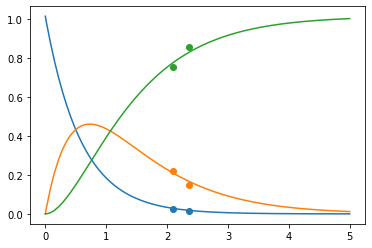

In [27]:
fig, ax = plt.subplots()
for c in ['A', 'B', 'C']:
    ax.scatter(r1.results.Cm.index, r1.results.Cm[c])
    ax.plot(r1.results.Z.index, r1.results.Z[c])

In [ ]:
results_pyomo.objective

In [ ]:
# since kipet outputs reduced hessian which equals covariance if right sigma values are specified. 
# since we just specified sigma=1, we need to adjust the covariance matrix output from KIPET to get the 
# estimated covariance matrix
mse = r1.results.objective / (C_data.shape[0]*3 - 5)
cov_est = 2 * mse * r1.results.parameter_covariance
cov_est

In [ ]:
dof = (C_data.shape[0]*3 - 5)
conf_delta = t.ppf(0.975, dof) * np.sqrt(np.diag(cov_est))
conf_delta

In [ ]:
# confidence limits of parameters
i = 0
for k, v in r1.results.P.items():
    print(f"{k}, {v - conf_delta[i]:.2f}, {v + conf_delta[i]:.2f}")
    i = i + 1